In [1]:
%matplotlib inline

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib

from Bio import SeqIO
from matplotlib import pyplot as plt
from os import path
from scipy.stats import binom
from utils import qual_palette

In [2]:
# Genome and pool data filenames
genome_fname = "../data/berkeleylab-feba-7de9bcaf0960/bin/g/Halo/genome.fna"
pool_fname1 = "../data/HnTnSeqAnalysis/DSJD02HTn1_R1/DSJDo2Htn1_S1_l006_R1_001.pool"
pool_fname2 = "../data/HnTnSeqAnalysis/DSJD03Htn2_R1/DSJD03Htn2_S2_l006_R1_001.pool"

gene_stats_fname1 = '../data/HnTnSeqAnalysis/geneStatsRep1.csv'
gene_stats_fname2 = '../data/HnTnSeqAnalysis/geneStatsRep2.csv'

# DataFrames for pool and gene data
pool_df1 = pd.read_csv(pool_fname1, sep='\t')
pool_df2 = pd.read_csv(pool_fname2, sep='\t')
rep_df1 = pd.read_csv(gene_stats_fname1)
rep_df2 = pd.read_csv(gene_stats_fname2)

# DataFrame for essentiality calls 
essentiality_fname = '../data/essentiality_calls.csv'
essentiality_df = pd.read_csv(essentiality_fname)

# Grab genome length
genome_size_bp = None
for req in SeqIO.parse(genome_fname, "fasta"):
    genome_size_bp = len(req)

In [5]:
# Aggregate statistics for the two replicate sequencings of our Hnea library.
print('genome size: %d bp' % genome_size_bp)

print()
print('First replicate TN-Seq Mapping:')

mask = pool_df1.pos.notnull()
insertions_rep1 = pool_df1[mask].pos.values
n_ins_rep1 = len(insertions_rep1)
ins_rate_rep1 = (n_ins_rep1 / genome_size_bp)

print('rep1 number of insertions: %d' % n_ins_rep1)
print('rep1 insertion/bp: %.2f' % ins_rate_rep1)
print('rep1 bp/insertion: %.2f' % (genome_size_bp / n_ins_rep1))
print('Average insertions per gene rep1: %.2f' % rep_df1.inserts.mean())

print()
print('Second replicate TN-Seq Mapping:')

mask = pool_df2.pos.notnull()
insertions_rep2 = pool_df2[mask].pos.values
n_ins_rep2 = len(insertions_rep2)
ins_rate_rep2 = (n_ins_rep2 / genome_size_bp)

print('rep2 number of insertions: %d' % n_ins_rep2)
print('rep2 insertion/bp: %.2f' % ins_rate_rep2)
print('rep2 bp/insertion: %.2f' % (genome_size_bp/n_ins_rep2))

print('Average insertions per gene rep1: %.2f' % rep_df2.inserts.mean())

genome size: 2582886 bp

First replicate TN-Seq Mapping:
rep1 number of insertions: 102511
rep1 insertion/bp: 0.04
rep1 bp/insertion: 25.20
Average insertions per gene rep1: 37.89

Second replicate TN-Seq Mapping:
rep2 number of insertions: 99429
rep2 insertion/bp: 0.04
rep2 bp/insertion: 25.98
Average insertions per gene rep1: 36.74


In [16]:
# When we are plotting the library we want to include insertions mapped in either replicate.
# Therefore we merge the two dataframes. 
merge_on = pool_df1.columns.tolist()
total_pool_df = pool_df1.merge(pool_df2, on=merge_on, how='outer')

array([     nan,      nan,      nan, ...,  750217., 1606868., 1547879.])

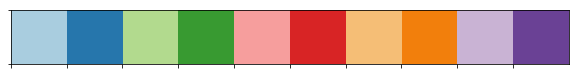

In [26]:
sns.palplot(qual_palette)

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


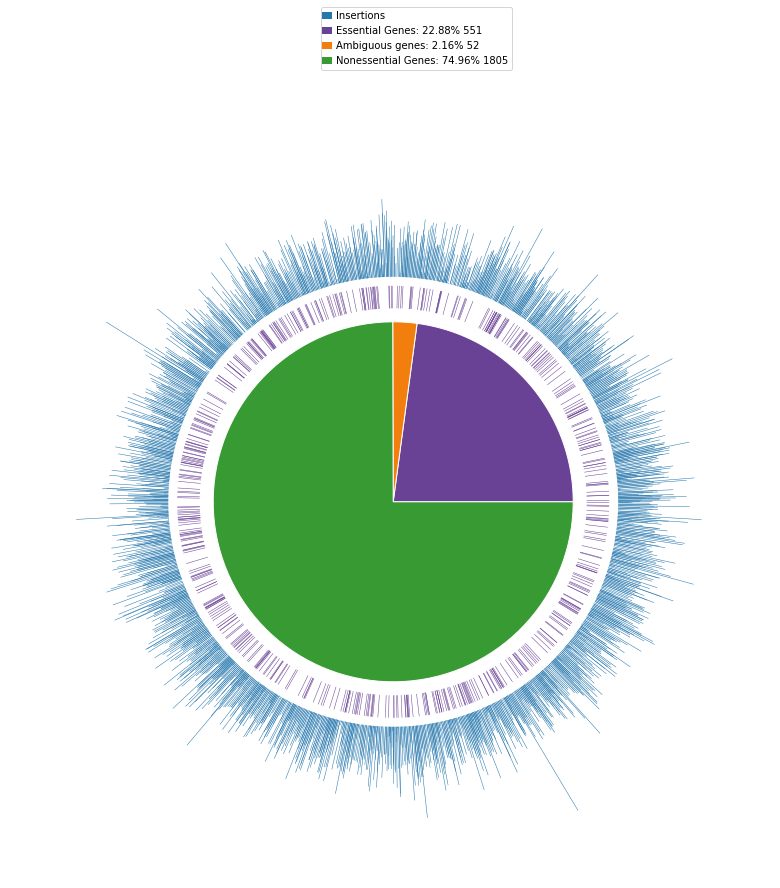

In [28]:
# Circular plot of insertions in the genome. 
colors = qual_palette
iCol = colors[1]
eCol = colors[9]
nCol = colors[3]
aCol = colors[7]

fig = plt.figure(figsize=(10,10),frameon=False)
ax=fig.add_axes([0,0,1,1], polar=True)

plt.ylim(0,8)

mapped_ins = total_pool_df.pos.notnull()
all_insertions = total_pool_df[mapped_ins].pos.values
bins = range(0, int(all_insertions.max()) + 1000, 1000)

hist, bins = np.histogram(all_insertions, bins=bins)
heights = ((hist/max(hist))*3)+5
ax.vlines(bins, [5]*len(insertions),heights, colors=iCol,linewidth=0.5)

mask_essentials = essentiality_df.essentiality == 'essential'
mask_amb = essentiality_df.essentiality == 'ambiguous'
mask_nonessential = essentiality_df.essentiality == 'nonessential'

essentials = essentiality_df[mask_essentials]
essentials_pos = essentials.begin

length = len(essentials)
ax.vlines(essentials_pos, [4.8]*length,[4.3]*length, colors=eCol,linewidth=0.5)
ax.axis('off')


size = [4]*3
dat=np.array([mask_essentials.sum(), mask_amb.sum(), mask_nonessential.sum()])
widths=dat/sum(dat)*2*np.pi
datleft=np.append(0,np.cumsum(widths)[:-1])
ax.bar(left=datleft,width=widths,bottom=0,height=size,color=[eCol,aCol,nCol],
       edgecolor='w', linewidth=1, align="edge")

lw=7
perc=(dat/sum(dat))*100
legend_elements = [matplotlib.lines.Line2D([0], [0], color=iCol, lw=lw, label='Insertions'),
                   matplotlib.lines.Line2D([0], [0], color=eCol, lw=lw, label='Essential Genes: '+str(round(perc[0],2))+'% '+str(dat[0])),
                  matplotlib.lines.Line2D([0], [0], color=aCol, lw=lw, label='Ambiguous genes: '+str(round(perc[1],2))+'% '+str(dat[1])),
                  matplotlib.lines.Line2D([0], [0], color=nCol, lw=lw, label='Nonessential Genes: '+str(round(perc[2],2))+'% '+str(dat[2])),]
ax.legend(handles=legend_elements, handlelength=0.3,loc=[0.4,1.1])

plt.savefig('fig1/fig1B.eps', format='eps', bbox_inches='tight')
plt.show()

In [ ]:
# Making Panel B
%matplotlib inline
def makePanelB(ax):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    
    import seaborn as sns
    cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
        ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
    colors = sns.color_palette(cols)
    
    insertColor=colors[1]
    essentialColor=colors[5]
    nonEssentialColor=colors[6]
    aCol=colors[12]

#     essentialColor=colors[1]
    
#     insertColor=colors[5]

#     nonEssentialColor=colors[6]

#     ax.text(0.5,0.5,'Operon Diagram of essential operons',va='center',ha='center',fontsize=20)
    pool_f = open("./HnTnSeqAnalysis/DSJD02HTn1_R1/DSJDo2Htn1_S1_l006_R1_001.pool", "r")
    pool_df = pd.read_table(pool_f)
    pool_f.close()
    pool_dropped_df =  pool_df[np.isfinite(pool_df['pos'])]
    insertions=pool_dropped_df.pos.values


    rep1 = pd.read_csv('./HnTnSeqAnalysis/geneStatsRep1.csv')
#     r1essentials = rep1[rep1['pvalCorrected']<(0.05/len(rep1))]
#     r1nonessentials = rep1[rep1['pvalCorrected']>=(0.05/len(rep1))]

    plt.ylim(0,1)
    ys=[0.2,0.5,0.8]
    regions=[(0,8000+500),(348299-3000,350747+3000),(428269-7000,430257+3000)]
    for i in [0,1,2]:
        y=ys[i]
        region=regions[i]
        regionStart=min(region)
        regionEnd=max(region)
        
        geneRegion = rep1[(rep1.begin>=regionStart)&(rep1.end<=regionEnd)]
        print(geneRegion.locusId)
        print(geneRegion.desc)
        insertRegion = pool_dropped_df[(pool_dropped_df.pos>=regionStart)&(pool_dropped_df.pos<=regionEnd)]
        width=0.05
        headwidth=0.085
        height = 0.07
        head_scale=0.2
        for i,gene in enumerate(geneRegion.index):
            
            length = geneRegion.loc[gene,'length']/(regionEnd-regionStart)
            
            if(length>0.03):
                head_length =0.03
            else:
                head_length=length*head_scale
            
            if((geneRegion.loc[gene,'pvalCorrected']<(0.05/len(rep1)))&(geneRegion.loc[gene,'length']>274)):
                c=essentialColor
            elif((geneRegion.loc[gene,'length']<=274)):
                c=aCol
            else:
                c=nonEssentialColor
            
            if(geneRegion.loc[gene,'strand']=='+'):
                start=(geneRegion.loc[gene,'begin']-regionStart)/(regionEnd-regionStart)
                genePic = mpl.patches.FancyArrow(start,y,length,
                                                 0,width=width,length_includes_head=True,head_width=headwidth,
                                                 head_length=head_length, fill=True,facecolor=c)
                ax.add_artist(genePic)
#                 plt.text(geneRegion.loc[gene,'begin']+(geneRegion.loc[gene,'length']*0.8)/2,y-headwidth*2,
#                          geneRegion.loc[gene,'sysName'], size=18, ha='center', va='center',
#                          color="k", rotation=90)
            else:
                start=(geneRegion.loc[gene,'end']-regionStart)/(regionEnd-regionStart)
                genePic = mpl.patches.FancyArrow(start,y,-length,
                                                 0,width=width,length_includes_head=True,head_width=headwidth,
                                                 head_length=head_length, fill=True,facecolor=c)
                ax.add_artist(genePic)
#                 plt.text(geneRegion.loc[gene,'end']-(geneRegion.loc[gene,'length']*0.8)/2,y-headwidth*2,
#                          geneRegion.loc[gene,'sysName'], size=18, ha='center', va='center',color="k", rotation=90)
        poses =(insertRegion.pos -regionStart)/(regionEnd-regionStart)        
        plt.vlines(poses,[y+height*1.3]*len(poses),
                   ([y+height*1.3]*len(poses))+(height*insertRegion.n/max(insertRegion.n)), colors='k')
        
        plt.vlines(poses,[y+height*0.8]*len(poses),
                   ([y+height*1.1]*len(poses)), colors=insertColor,linewidth=0.75)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
fig,ax = plt.subplots(figsize=(10,10), frameon=False)
makePanelB(ax)
plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig1PanelC.eps',format='eps',bbox_inches='tight')
plt.show()

In [ ]:
cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
        ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
colors = sns.color_palette(cols)
sns.palplot(pal)
plt.show()

In [ ]:
# # Making Panel D
# %matplotlib inline
# def makePanelD(ax):
#     import adjustText

#     import seaborn as sns
#     cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
#             ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
#     colors = sns.color_palette(cols)    
#     iCol=colors[0] #non-CCM genes
#     eCol=colors[4]  #known CCM genes
#     nCol=colors[7] #known non-CCM genes
#     aCol=colors[6]  #new genes
    
#     import pandas as pd
#     from os import path

    
#     pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
#     gene_counts_df = pd.read_csv(path.join(pathToData, 'all.poolcount'), sep='\t')
#     logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
#     tValues_df = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
#     smaller_df = pd.DataFrame()
#     smaller_df["barcode"] = gene_counts_df["barcode"]
#     smaller_df["locusId"] = gene_counts_df["locusId"]
#     smaller_df["Initial"] = gene_counts_df["test.S1"]
#     smaller_df["HighCO2"] = gene_counts_df["test.S2"]
#     smaller_df["LowCO2"] = gene_counts_df["test.S3"]

#     # smaller_df
#     small_log_df = pd.DataFrame()
#     small_t_df = pd.DataFrame()
#     small_log_df["locusId"] = logratios_df["locusId"]
#     small_log_df["sysName"] = logratios_df["sysName"]
#     small_log_df["desc"] = logratios_df["desc"]
#     small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
#     small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]

#     small_t_df["locusId"] = tValues_df["locusId"]
#     small_t_df["HighCO2T"] = tValues_df["setAS2 HCO"]
#     small_t_df["LowCO2T"] = tValues_df["setAS3 LCO"]

#     testStatiscticsRep1 = pd.merge(small_log_df, small_t_df, how='left', on='locusId')
    
#     pathToData = "./../RB-TnSeq/2017_11_03_miseq_barseq2/"
#     gene_counts_df = pd.read_csv(path.join(pathToData, 'all.poolcount'), sep='\t')
#     logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
#     tValues_df = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
#     smaller_df = pd.DataFrame()
#     smaller_df["barcode"] = gene_counts_df["barcode"]
#     smaller_df["locusId"] = gene_counts_df["locusId"]
#     smaller_df["Initial"] = gene_counts_df["test.S1"]
#     smaller_df["HighCO2"] = gene_counts_df["test.S2"]
#     smaller_df["LowCO2"] = gene_counts_df["test.S3"]

#     # smaller_df
#     small_log_df = pd.DataFrame()
#     small_t_df = pd.DataFrame()
#     small_log_df["locusId"] = logratios_df["locusId"]
#     small_log_df["sysName"] = logratios_df["sysName"]
#     small_log_df["desc"] = logratios_df["desc"]
#     small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
#     small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]

#     small_t_df["locusId"] = tValues_df["locusId"]
#     small_t_df["HighCO2T"] = tValues_df["setAS2 HCO"]
#     small_t_df["LowCO2T"] = tValues_df["setAS3 LCO"]

#     testStatiscticsRep2 = pd.merge(small_log_df, small_t_df, how='left', on='locusId')
    
#     means=pd.concat([testStatiscticsRep1,testStatiscticsRep2]).groupby('locusId').mean()
# #     print(means.head(10))
# #     print(means.loc['HNEAP_RS04625'])
    
    
#     expected_hits = {
#         'HNEAP_RS04625': 'csos1A',
#         'HNEAP_RS04620': 'csos1B',
#         'HNEAP_RS04630': 'csos1C',
#         'HNEAP_RS04635': 'csos4B',
#         'HNEAP_RS04640': 'csos4A',
#         'HNEAP_RS04650': 'csos2',
#         'HNEAP_RS04660': 'cbbL',
#         'HNEAP_RS04655': 'cbbS',
#         'HNEAP_RS04645': 'csosCA',
#         'HNEAP_RS04565':'csos1D',
#     }

#     keys = sorted(expected_hits.keys())
#     vals = [expected_hits[k] for k in keys]
#     expected_hits_data = means[means.index.isin(keys)]

#     unexpected_hits = {
#         'HNEAP_RS01030':'DAB2A',
#         'HNEAP_RS01035':'DAB2B',
#         'HNEAP_RS01040':'LysR family',
#         'HNEAP_RS04615':'acRAF', #Pterin-4a-carbinolamine dehydratase
#         'HNEAP_RS05490':'LysR family',
#         'HNEAP_RS07320':'Crp/Fnr',
#         'HNEAP_RS04585':'DAB1A',
#         'HNEAP_RS04595':'DAB1B',
#         'HNEAP_RS05865':'TPR_16',#Tetratricopeptide TPR_2 repeat protein
#     #     'HNEAP_RS05380':'Lytic transglycosylase catalytic',
#     #     'HNEAP_RS08465':'N-acetylmuramyl-L-alanine amidase, negative regulator of AmpC, AmpD'
#     }

#     ukeys = sorted(unexpected_hits.keys())
#     uvals = [unexpected_hits[k] for k in ukeys]
#     unexpected_hits_data = means[means.index.isin(ukeys)]




#     expected_misses = {
#         'HNEAP_RS05505': 'RuBisCO F2'
#     }

#     mkeys = sorted(expected_misses.keys())
#     mvals = [expected_misses[k] for k in mkeys]
#     expected_misses_data = means[means.index.isin(mkeys)]

#     plt.scatter(means.HighCO2Log, means.LowCO2Log, c=iCol,edgecolors='k', s=100,label='Non-CCM Genes')
#     plt.scatter(expected_hits_data.HighCO2Log, expected_hits_data.LowCO2Log, c=eCol,edgecolors='k', s=100,label='Known CCM Genes')
#     plt.scatter(expected_misses_data.HighCO2Log, expected_misses_data.LowCO2Log, c=nCol,edgecolors='k', s=100,label='Known Non-CCM Gene')
#     plt.scatter(unexpected_hits_data.HighCO2Log, unexpected_hits_data.LowCO2Log, c=aCol,edgecolors='k', s=100,label='New CCM Genes')
#     plt.legend(loc=3)

#     texts = []

#     for k, v in zip(keys, vals):
#         l=v
#         data = means[means.index == k]
#         x, y = data.HighCO2Log, data.LowCO2Log
#         texts.append(plt.text(x, y, l, size=16))
#     for k, v in zip(mkeys, mvals):
#         l=v
#         data = means[means.index == k]
#         x, y = data.HighCO2Log, data.LowCO2Log
#         texts.append(plt.text(x, y, l, size=16))
#     for k, v in zip(ukeys, uvals):
#         l=v
#         data = means[means.index == k]
#         x, y = data.HighCO2Log, data.LowCO2Log
#         texts.append(plt.text(x, y, l, size=16))
#     x=means.HighCO2Log
#     y=means.LowCO2Log
#     adjustText.adjust_text(texts,x=x,y=y,arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    
# #     plt.scatter(means.HighCO2Log, means.LowCO2Log, c='g',edgecolors='k', s=100)
    
#     plt.xlabel('log2(Fitness in 5% CO2)', fontsize=16)
#     plt.ylabel('log2(Fitness in Ambient)', fontsize=16)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
        
   
# fig,ax = plt.subplots(figsize=(10,10), frameon=False)
# makePanelD(ax)
# plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig2PanelB.eps',
#            format='eps',bbox_inches='tight')
# plt.show()

In [ ]:
# Making Panel D
%matplotlib inline
def makePanelD(ax):
    import adjustText

    import seaborn as sns
    cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
            ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
    colors = sns.color_palette(cols)    
#     iCol=colors[3] #in operon
    iCol=colors[9] #in operon
    eCol=colors[4]  #known CCM genes
    nCol=colors[7] #known non-CCM genes
    aCol=colors[6]  #out of operon
    
    import pandas as pd
    import numpy as np
    from os import path

    
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
    gene_counts_df = pd.read_csv(path.join(pathToData, 'all.poolcount'), sep='\t')
    logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    tValues_df = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
    smaller_df = pd.DataFrame()
    smaller_df["barcode"] = gene_counts_df["barcode"]
    smaller_df["locusId"] = gene_counts_df["locusId"]
    smaller_df["Initial"] = gene_counts_df["test.S1"]
    smaller_df["HighCO2"] = gene_counts_df["test.S2"]
    smaller_df["LowCO2"] = gene_counts_df["test.S3"]

    # smaller_df
    small_log_df = pd.DataFrame()
    small_t_df = pd.DataFrame()
    small_log_df["locusId"] = logratios_df["locusId"]
    small_log_df["sysName"] = logratios_df["sysName"]
    small_log_df["desc"] = logratios_df["desc"]
    small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
    small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]

    small_t_df["locusId"] = tValues_df["locusId"]
    small_t_df["HighCO2T"] = tValues_df["setAS2 HCO"]
    small_t_df["LowCO2T"] = tValues_df["setAS3 LCO"]
    
    geneLocs_df = pd.read_csv(path.join(pathToData, 'genes'), sep='\t')
#     cbbLocus_df = geneLocs_df[(geneLocs_df.begin>(983926-10000))&(geneLocs_df.begin<(983926+10000))]
    cbbLocus_df = geneLocs_df[(geneLocs_df.begin>(971679-100))&(geneLocs_df.begin<(989858+100))]



    testStatiscticsRep1 = pd.merge(small_log_df, small_t_df, how='left', on='locusId')
    
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barseq2/"
    gene_counts_df = pd.read_csv(path.join(pathToData, 'all.poolcount'), sep='\t')
    logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    tValues_df = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
    smaller_df = pd.DataFrame()
    smaller_df["barcode"] = gene_counts_df["barcode"]
    smaller_df["locusId"] = gene_counts_df["locusId"]
    smaller_df["Initial"] = gene_counts_df["test.S1"]
    smaller_df["HighCO2"] = gene_counts_df["test.S2"]
    smaller_df["LowCO2"] = gene_counts_df["test.S3"]

    # smaller_df
    small_log_df = pd.DataFrame()
    small_t_df = pd.DataFrame()
    small_log_df["locusId"] = logratios_df["locusId"]
    small_log_df["sysName"] = logratios_df["sysName"]
    small_log_df["desc"] = logratios_df["desc"]
    small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
    small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]

    small_t_df["locusId"] = tValues_df["locusId"]
    small_t_df["HighCO2T"] = tValues_df["setAS2 HCO"]
    small_t_df["LowCO2T"] = tValues_df["setAS3 LCO"]

    testStatiscticsRep2 = pd.merge(small_log_df, small_t_df, how='left', on='locusId')
    
    means=pd.concat([testStatiscticsRep1,testStatiscticsRep2]).groupby('locusId').mean()
#     print(means.head(10))
#     print(means.loc['HNEAP_RS04625'])
    
    
    expected_hits = {
        'HNEAP_RS04625': 'csos1A',
        'HNEAP_RS04620': 'csos1B',
        'HNEAP_RS04630': 'csos1C',
        'HNEAP_RS04635': 'csos4B',
        'HNEAP_RS04640': 'csos4A',
        'HNEAP_RS04650': 'csos2',
        'HNEAP_RS04660': 'cbbL',
        'HNEAP_RS04655': 'cbbS',
        'HNEAP_RS04645': 'csosCA',
        'HNEAP_RS04565':'csos1D',
    }

    keys = sorted(expected_hits.keys())
    vals = [expected_hits[k] for k in keys]
    expected_hits_data = means[means.index.isin(keys)]

    unexpected_hits = {
        'HNEAP_RS01030':'DAB2A',
        'HNEAP_RS01035':'DAB2B',
        'HNEAP_RS01040':'LysR family',
        'HNEAP_RS04615':'acRAF', #Pterin-4a-carbinolamine dehydratase
        'HNEAP_RS05490':'LysR family',
        'HNEAP_RS07320':'Crp/Fnr',
        'HNEAP_RS04585':'DAB1A',
        'HNEAP_RS04595':'DAB1B',
        'HNEAP_RS05865':'TPR_16',#Tetratricopeptide TPR_2 repeat protein
    #     'HNEAP_RS05380':'Lytic transglycosylase catalytic',
    #     'HNEAP_RS08465':'N-acetylmuramyl-L-alanine amidase, negative regulator of AmpC, AmpD'
    }

    ukeys = sorted(unexpected_hits.keys())
    uvals = [unexpected_hits[k] for k in ukeys]
    unexpected_hits_data = means[means.index.isin(ukeys)]

    
# #     print(means)
    
    cbbLoc_toPlot = means[means.index.isin(cbbLocus_df.locusId)]

#     print(means)
    
    plt.scatter(means.HighCO2Log, means.LowCO2Log, c=aCol,edgecolors='k', s=100,
                label='Outside operon')
    plt.scatter(cbbLoc_toPlot.HighCO2Log, cbbLoc_toPlot.LowCO2Log, c=iCol,edgecolors='k', s=100,
                label='In extended operon')
#     plt.legend(loc=3)

    texts = []
    
    matplotlib.rcParams.update({'font.size': 30})
    
    for k, v in zip(keys, vals):
        l=v
        data = means[means.index == k]
        x, y = data.HighCO2Log, data.LowCO2Log
        texts.append(plt.text(x, y, l, size=16))
#     for k, v in zip(mkeys, mvals):
#         l=v
#         data = means[means.index == k]
#         x, y = data.HighCO2Log, data.LowCO2Log
#         texts.append(plt.text(x, y, l, size=16))
    for k, v in zip(ukeys, uvals):
        l=v
        data = means[means.index == k]
        x, y = data.HighCO2Log, data.LowCO2Log
        texts.append(plt.text(x, y, l, size=16))
    x=means.HighCO2Log
    y=means.LowCO2Log
    adjustText.adjust_text(texts,x=x,y=y,arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    
    
#     plt.scatter(means.HighCO2Log, means.LowCO2Log, c='g',edgecolors='k', s=100)
    
    plt.xlabel('Fitness in 5% CO$_2$')
    plt.ylabel('Fitness in Ambient CO$_2$')
    plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                    length=10, width=4)
        # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
#     change axis weight
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    locs,labels = plt.xticks()
    ticks=['2$^{'+str(int(x))+'}$' for x in locs]
    plt.xticks(locs,ticks)#,rotation=45)
    locs,labels = plt.yticks()
    ticks=['2$^{'+str(int(x))+'}$' for x in locs]
    plt.yticks(locs,ticks)
        
   
fig,ax = plt.subplots(figsize=(10,10), frameon=False)
makePanelD(ax)
plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig2PanelB.eps',
           format='eps',bbox_inches='tight')
plt.show()

In [ ]:
def makeFig2S1():
    import pandas as pd
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
    logratios_df1 = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    tValues_df1 = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barseq2/"
    logratios_df2 = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    tValues_df2 = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
    

In [ ]:
# Making Panel D
%matplotlib inline
def makePanelD(ax):
    import adjustText

    import seaborn as sns
    cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
            ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
    colors = sns.color_palette(cols)    
#     iCol=colors[3] #in operon
    iCol=colors[9] #in operon
    eCol=colors[4]  #known CCM genes
    nCol=colors[7] #known non-CCM genes
    aCol=colors[6]  #out of operon
    
    import pandas as pd
    import numpy as np
    from os import path

    
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
    gene_counts_df = pd.read_csv(path.join(pathToData, 'all.poolcount'), sep='\t')
    logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    tValues_df = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
    smaller_df = pd.DataFrame()
    smaller_df["barcode"] = gene_counts_df["barcode"]
    smaller_df["locusId"] = gene_counts_df["locusId"]
    smaller_df["Initial"] = gene_counts_df["test.S1"]
    smaller_df["HighCO2"] = gene_counts_df["test.S2"]
    smaller_df["LowCO2"] = gene_counts_df["test.S3"]

    # smaller_df
    small_log_df = pd.DataFrame()
    small_t_df = pd.DataFrame()
    small_log_df["locusId"] = logratios_df["locusId"]
    small_log_df["sysName"] = logratios_df["sysName"]
    small_log_df["desc"] = logratios_df["desc"]
    small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
    small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]

    small_t_df["locusId"] = tValues_df["locusId"]
    small_t_df["HighCO2T"] = tValues_df["setAS2 HCO"]
    small_t_df["LowCO2T"] = tValues_df["setAS3 LCO"]
    
    geneLocs_df = pd.read_csv(path.join(pathToData, 'genes'), sep='\t')
#     cbbLocus_df = geneLocs_df[(geneLocs_df.begin>(983926-10000))&(geneLocs_df.begin<(983926+10000))]
    cbbLocus_df = geneLocs_df[(geneLocs_df.begin>(971679-100))&(geneLocs_df.begin<(989858+100))]



    testStatiscticsRep1 = pd.merge(small_log_df, small_t_df, how='left', on='locusId')
    
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barseq2/"
    gene_counts_df = pd.read_csv(path.join(pathToData, 'all.poolcount'), sep='\t')
    logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    tValues_df = pd.read_csv(path.join(pathToData, 'fit_t.tab'), sep='\t')
    smaller_df = pd.DataFrame()
    smaller_df["barcode"] = gene_counts_df["barcode"]
    smaller_df["locusId"] = gene_counts_df["locusId"]
    smaller_df["Initial"] = gene_counts_df["test.S1"]
    smaller_df["HighCO2"] = gene_counts_df["test.S2"]
    smaller_df["LowCO2"] = gene_counts_df["test.S3"]

    # smaller_df
    small_log_df = pd.DataFrame()
    small_t_df = pd.DataFrame()
    small_log_df["locusId"] = logratios_df["locusId"]
    small_log_df["sysName"] = logratios_df["sysName"]
    small_log_df["desc"] = logratios_df["desc"]
    small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
    small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]

    small_t_df["locusId"] = tValues_df["locusId"]
    small_t_df["HighCO2T"] = tValues_df["setAS2 HCO"]
    small_t_df["LowCO2T"] = tValues_df["setAS3 LCO"]

    testStatiscticsRep2 = pd.merge(small_log_df, small_t_df, how='left', on='locusId')
    
    means=pd.concat([testStatiscticsRep1,testStatiscticsRep2]).groupby('locusId').mean()
#     print(means.head(10))
#     print(means.loc['HNEAP_RS04625'])
    

    labeled_stuff = [
        ('HNEAP_RS04625', 'Csos1A',0.11,-4.5),
        ('HNEAP_RS04620', 'Csos1B',-0.1,-1.6),
        ('HNEAP_RS04630', 'Csos1C',0,-7),
        ('HNEAP_RS04635', 'Csos4B',0.1,-5.9),
        ('HNEAP_RS04640', 'Csos4A',-1.5,-6.5),
        ('HNEAP_RS04650', 'Csos2',0.1,-6.4),
        ('HNEAP_RS04660', 'CbbL',-0.9,-5.2),
        ('HNEAP_RS04655', 'CbbS',0,-4.1),
        ('HNEAP_RS04645', 'CsosCA',0.15,-5),
        ('HNEAP_RS04565','Csos1D',-0.05,-1.15),
        ('HNEAP_RS01030','DabAB2',0.1,-3.3),
#         ('HNEAP_RS01035','DabB2',1,1),
        ('HNEAP_RS01040','LysR',0.15,-2.6),
        ('HNEAP_RS04615','acRAF',-1.5,-4), #Pterin-4a-carbinolamine dehydratase
        ('HNEAP_RS05490','LysR',-0.8,-6),
        ('HNEAP_RS07320','Crp/Fnr',0,-2.1),
        ('HNEAP_RS04585','DabAB1',-1.5,-2.1),
#         ('HNEAP_RS04595','DabB1',1,1),
#         ('HNEAP_RS05865','TPR_16',1,1),#Tetratricopeptide TPR_2 repeat protein
    #     'HNEAP_RS05380':'Lytic transglycosylase catalytic',
    #     'HNEAP_RS08465':'N-acetylmuramyl-L-alanine amidase, negative regulator of AmpC, AmpD'
    ]

    for gene,label,x,y in labeled_stuff:
        plt.text(x,y,label,fontsize=26)
    
# #     print(means)
    
    cbbLoc_toPlot = means[means.index.isin(cbbLocus_df.locusId)]

#     print(means)
    
    plt.scatter(means.HighCO2Log, means.LowCO2Log, c=aCol,edgecolors='k', s=100,
                label='Outside operon')
    plt.scatter(cbbLoc_toPlot.HighCO2Log, cbbLoc_toPlot.LowCO2Log, c=iCol,edgecolors='k', s=100,
                label='In extended operon')

    
    matplotlib.rcParams.update({'font.size': 30})
    
    
    
#     plt.scatter(means.HighCO2Log, means.LowCO2Log, c='g',edgecolors='k', s=100)
    
    plt.xlabel('Fitness in 5% CO$_2$')
    plt.ylabel('Fitness in Ambient CO$_2$')
    plt.tick_params(axis='both', direction='out', bottom='on', left='on', top='off', right='off',
                    length=10, width=4)
        # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
#     change axis weight
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    locs,labels = plt.xticks()
    ticks=['2$^{'+str(int(x))+'}$' for x in locs]
    plt.xticks(locs,ticks)#,rotation=45)
    locs,labels = plt.yticks()
    ticks=['2$^{'+str(int(x))+'}$' for x in locs]
    plt.yticks(locs,ticks)
        
   
fig,ax = plt.subplots(figsize=(10,10), frameon=False)
makePanelD(ax)
plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig2PanelB.eps',format='eps',bbox_inches='tight')
plt.show()

In [ ]:
cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
        ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
colors = sns.color_palette(cols)
sns.palplot(pal)
plt.show()

In [ ]:
# # Making Panel C
# %matplotlib inline
# import matplotlib.pyplot as plt

# def makePanelC(ax):
#     import pandas as pd
#     import numpy as np
#     import matplotlib as mpl
#     from os import path
#     import matplotlib.pyplot as plt

#     import seaborn as sns

#     cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
#             ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
#     colors = sns.color_palette(cols)    
# #     iCol=colors[0] #non-CCM genes
# #     eCol=colors[4]  #known CCM genes
# #     nCol=colors[7] #known non-CCM genes
# #     aCol=colors[6]  #new genes
    
#     insertColor=colors[0]
#     essentialColor=colors[4]
#     nonEssentialColor=colors[7]
#     aCol=colors[6]
    
# #         iCol=colors[2]
# #     eCol=colors[4]
# #     nCol=colors[7]
# #     aCol=colors[6]
    
#     pool_f = open("./../RB-TnSeq/2017_11_03_miseq_barSeq1/all.poolcount", "r")
#     pool_df = pd.read_table(pool_f)
#     pool_f.close()
#     abundanceS1 = pool_df['test.S1']/sum(pool_df['test.S1'])
#     abundanceS2 = pool_df['test.S2']/sum(pool_df['test.S2'])
#     abundanceS3 = pool_df['test.S3']/sum(pool_df['test.S3'])
#     vals=(abundanceS2/abundanceS1)-(abundanceS3/abundanceS1)
#     nval=vals/max(np.abs(vals))
#     pool_df['val']=nval
#     pool_dropped_df =  pool_df[np.isfinite(pool_df['val'])]
# #     nMax=1.2
# #     nMin=3.4
# #     oMax=max(pool_dropped_df['val'])
# #     oMin=min(pool_dropped_df['val'])
# #     roll=((pool_dropped_df['val']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
# #     zero=((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
# #     pool_dropped_df['val']=roll

#     rep1 = pd.read_csv('./HnTnSeqAnalysis/geneStatsRep1.csv')
#     pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
#     logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
#     # smaller_df
#     small_log_df = pd.DataFrame()
#     small_log_df["locusId"] = logratios_df["locusId"]
#     small_log_df["sysName"] = logratios_df["sysName"]
#     small_log_df["desc"] = logratios_df["desc"]
#     small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
#     small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]
#     small_log_df=small_log_df[small_log_df.LowCO2Log -small_log_df.HighCO2Log<-0.5]

#     y=1
#     height=1
#     window_size=300
#     ys=[0.15,0.45,0.75]
#     regions=[(983594-1000,986794+8000),(983594-13000,983594),(216936-3000,219419+6000)]
#     for i in [0,1,2]:
#         y=ys[i]
#         region=regions[i]
#         regionStart=min(region)
#         regionEnd=max(region)
#         rolMed=[0]*(regionEnd-regionStart)
#         geneRegion = rep1[(rep1.begin>=regionStart)&(rep1.end<=regionEnd)]
#         print(geneRegion.locusId)
#         print(geneRegion.desc)
#         insertRegion = pool_dropped_df[(pool_dropped_df.pos>=regionStart)&(pool_dropped_df.pos<=regionEnd)]
#         width=0.05
#         headwidth=0.085
#         height = 0.07
#         head_scale=0.2
#         for i,gene in enumerate(geneRegion.index):

#             length = geneRegion.loc[gene,'length']/(regionEnd-regionStart)

#             if(length>0.03):
#                 head_length =0.03
#             else:
#                 head_length=length*head_scale

#             if(sum(small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId']))):
#                 c=essentialColor
#             else:
#                 c=nonEssentialColor

#             if(geneRegion.loc[gene,'strand']=='+'):
#                 start=(geneRegion.loc[gene,'begin']-regionStart)/(regionEnd-regionStart)
#                 genePic = mpl.patches.FancyArrow(start,y,length,
#                                                  0,width=width,length_includes_head=True,head_width=headwidth,
#                                                  head_length=head_length, fill=True,facecolor=c)
#                 ax.add_artist(genePic)
#         #                 plt.text(geneRegion.loc[gene,'begin']+(geneRegion.loc[gene,'length']*0.8)/2,y-headwidth*2,
#         #                          geneRegion.loc[gene,'sysName'], size=18, ha='center', va='center',
#         #                          color="k", rotation=90)
#             else:
#                 start=(geneRegion.loc[gene,'end']-regionStart)/(regionEnd-regionStart)
#                 genePic = mpl.patches.FancyArrow(start,y,-length,
#                                                  0,width=width,length_includes_head=True,head_width=headwidth,
#                                                  head_length=head_length, fill=True,facecolor=c)
#                 ax.add_artist(genePic)

#         plt.ylim(0,1)
#         poses =(insertRegion.pos -regionStart)/(regionEnd-regionStart)
#         window_size=300
#         for p in range(regionStart,regionEnd):
#             window=0
#             if(p<=window_size/2):
#                 window = pool_dropped_df.val[pool_dropped_df.pos<window_size]
#             else:
#                 window = pool_dropped_df.val[(pool_dropped_df.pos>(p-window_size/2))&(pool_dropped_df.pos<(p+window_size/2))]
#             if(not window.empty):
#                 rolMed[p-regionStart]=np.nanmedian(window)
#             else:
#                 rolMed[p-regionStart]=np.nan
#         np.array(rolMed)
#         bases=(np.array(range(regionStart,regionEnd))-regionStart)/(regionEnd-regionStart)
#         roll = np.array(rolMed)
#         nMax=1.2
#         nMin=3.4
#         oMax=max(roll)
#         oMin=min(roll)
#         roll=((roll-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#         zero=((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#         plt.plot(bases,(height*roll)+(y),c=aCol)
#         ax.axhline(y=(height*zero)+(y),c='k')
# #         plt.vlines(bases,[y+height*2.3]*len(bases),
# #                    ([y+height*2.3]*len(bases))+(height*2*rolMed), colors='k')
        
#         plt.vlines(poses,[y+height*0.8]*len(poses),
#                    ([y+height*1.1]*len(poses)), colors=insertColor,linewidth=0.75)
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
    
# fig,ax = plt.subplots(figsize=(10,10), frameon=False)
# makePanelC(ax)
# plt.show()

In [ ]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

In [ ]:
def precomputeRollingEnrichment(do):
    import pandas as pd
    window_size=300
    if(do):
        print('Doing')
        import numpy as np
        from os import path

        pool_f = open("./../RB-TnSeq/2017_11_03_miseq_barSeq1/all.poolcount", "r")
        pool_df = pd.read_table(pool_f)
        pool_f.close()
        abundanceS1 = pool_df['test.S1']/sum(pool_df['test.S1'])
        abundanceS2 = pool_df['test.S2']/sum(pool_df['test.S2'])
        abundanceS3 = pool_df['test.S3']/sum(pool_df['test.S3'])
        vals=(abundanceS2/abundanceS1)-(abundanceS3/abundanceS1)
        nval=vals/max(np.abs(vals))
        pool_df['val']=nval
        pool_dropped_df =  pool_df[np.isfinite(pool_df['val'])]

        
        regionStart = int(min(pool_dropped_df.pos))
        print(regionStart)
        regionEnd = int(max(pool_dropped_df.pos))
        print(regionEnd)
        print(len(range(regionStart,regionEnd)))
        rolMed=[0]*(regionEnd-regionStart)
        for p in range(regionStart,regionEnd):
            printProgressBar(p,len(range(regionStart,regionEnd)))
            window=0
            if((p-regionStart)<=window_size/2):
                window = pool_dropped_df.val[(pool_dropped_df.pos-regionStart)<window_size]
            elif((regionEnd-p)<=window_size/2):
                window = pool_dropped_df.val[(regionEnd-pool_dropped_df.pos)<window_size]
            else:
                window = pool_dropped_df.val[(pool_dropped_df.pos>(p-window_size/2))&(pool_dropped_df.pos<(p+window_size/2))]
            if(not window.empty):
                rolMed[p-regionStart]=np.nanmedian(window)
            else:
                rolMed[p-regionStart]=np.nan
        poses = np.array([range(regionStart,regionEnd),rolMed])
        rollingWindow = pd.DataFrame(data=np.transpose(poses),columns=['position','EnrichmentWWindow'+str(window_size)])
        rollingWindow.to_csv("./../RB-TnSeq/2017_11_03_miseq_barSeq1/EnrichmentWWindow"+str(window_size))
        return(rollingWindow)
    else:
        print('notDoing')
        rollingWindow=pd.read_csv("./../RB-TnSeq/2017_11_03_miseq_barSeq1/EnrichmentWWindow"+str(window_size))
        return(rollingWindow)
        
rollingWindow=precomputeRollingEnrichment(False)
rollingWindow

In [ ]:
# # Making Panel C
# %matplotlib inline
# import matplotlib.pyplot as plt

# def makePanelC(ax):
#     import pandas as pd
#     import numpy as np
#     import matplotlib as mpl
#     from os import path
#     import matplotlib.pyplot as plt
#     from matplotlib import scale as mscale
#     from matplotlib import transforms as mtransforms

#     import seaborn as sns

#     cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
#             ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
#     colors = sns.color_palette(cols)    
# #     iCol=colors[0] #non-CCM genes
# #     eCol=colors[4]  #known CCM genes
# #     nCol=colors[7] #known non-CCM genes
# #     aCol=colors[6]  #new genes
    
#     insertColor=colors[0]
#     essentialColor=colors[4]
#     nonEssentialColor=colors[7]
#     aCol=colors[6]
    

#     window_size = 300
#     pool_f = open("/Volumes/Shared/data/Jack/SavageLab/RB-TnSeq/2017_11_03_miseq_barSeq1/EnrichmentWWindow"+str(window_size), "r")
#     pool_df = pd.read_table(pool_f,sep=',')
#     pool_f.close()
#     pool_dropped_df =  pool_df.dropna()
    
    
#     inserts_f = open("/Volumes/Shared/data/Jack/SavageLab/RB-TnSeq/2017_11_03_miseq_barSeq1/all.poolcount", "r")
#     inserts_df = pd.read_table(inserts_f)
#     inserts_f.close()
    
#     inserts_dropped_df = inserts_df.dropna(subset=['pos'])
# #     nMax=1.2
# #     nMin=3.4
# #     oMax=max(pool_dropped_df['val'])
# #     oMin=min(pool_dropped_df['val'])
# #     roll=((pool_dropped_df['val']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
# #     zero=((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
# #     pool_dropped_df['val']=roll

#     rep1 = pd.read_csv('/Volumes/Shared/data/Jack/SavageLab/scripts/HnTnSeqAnalysis/geneStatsRep1.csv')
#     pathToData = "/Volumes/Shared/data/Jack/SavageLab/RB-TnSeq/2017_11_03_miseq_barSeq1/"
#     logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
#     # smaller_df
#     small_log_df = pd.DataFrame()
#     small_log_df["locusId"] = logratios_df["locusId"]
#     small_log_df["sysName"] = logratios_df["sysName"]
#     small_log_df["desc"] = logratios_df["desc"]
#     small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
#     small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]
#     small_log_df=small_log_df[small_log_df.LowCO2Log -small_log_df.HighCO2Log<-0.5]

#     height=1
#     region=[(983594-13000,986794+8000),(216936-3000,219419+6000)]
    
#     region.sort()
#     print(region)
#     positions=[]
#     for reg in region:
#     #     print(reg)
#         positions.extend(list(range(reg[0],reg[1])))
#         positions.extend([np.nan]*50)
#     positions=np.array(positions)
#     positions_dropped = positions[~np.isnan(positions)]

    
#     def CustomScaleFactory(l, u):
#         class CustomScale(mscale.ScaleBase):
#             name = 'custom'

#             def __init__(self, axis, **kwargs):
#                 mscale.ScaleBase.__init__(self)
#                 self.thresh = None #thresh

#             def get_transform(self):
#                 return self.CustomTransform(self.thresh)

#             def set_default_locators_and_formatters(self, axis):
#                 pass

#             class CustomTransform(mtransforms.Transform):
#                 input_dims = 1
#                 output_dims = 1
#                 is_separable = True
#                 lower = l
#                 upper = u
#                 def __init__(self, thresh):
#                     mtransforms.Transform.__init__(self)
#                     self.thresh = thresh

#                 def transform_non_affine(self, a):
#                     aa=np.array(a)
#                     aaa = np.array(a)
#                     aaa[aa>self.lower] = aa[aa>self.lower]-(self.upper-self.lower)
#                     aaa[(aa>self.lower)&(aa<self.upper)] = self.lower
#                     return aaa

#                 def inverted(self):
#                     return CustomScale.InvertedCustomTransform(self.thresh)

#             class InvertedCustomTransform(mtransforms.Transform):
#                 input_dims = 1
#                 output_dims = 1
#                 is_separable = True
#                 lower = l
#                 upper = u

#                 def __init__(self, thresh):
#                     mtransforms.Transform.__init__(self)
#                     self.thresh = thresh

#                 def transform(self, a):
#                     aa=np.array(a)
#                     aaa = np.array(a)
#                     aaa[aa>self.lower] = aaa[aa>self.lower]+(self.upper-self.lower)
#                     return aaa

#                 def inverted(self):
#                     return CustomScale.CustomTransform(self.thresh)

#         return CustomScale

#     mscale.register_scale(CustomScaleFactory(region[0][1]+500, region[1][0]-500))
#     plt.gca().set_xscale('custom')
    
#     y=0.45
#     rolMed=[0]*(len(positions_dropped))
#     geneRegion = rep1[((rep1.begin.isin(positions_dropped))&(rep1.end.isin(positions_dropped)))]
#     print(geneRegion.locusId)
#     print(geneRegion.desc)
# #     print(pool_dropped_df)
# #     print(pool_dropped_df.iloc[:,1])
# #     print(pool_dropped_df['position'])
#     insertRegion = pool_dropped_df[pool_dropped_df.position.isin(positions_dropped)]
#     poses = inserts_dropped_df[inserts_dropped_df.pos.isin(positions_dropped)].pos
#     width=0.05
#     headwidth=0.085
#     height = 0.07
#     head_scale=1
    
#     for i,gene in enumerate(geneRegion.index):

#         length = geneRegion.loc[gene,'length']
        
#         hl=500
#         if(length>hl):
#             head_length = hl
#         else:
#             head_length=length*head_scale

#         if(sum(small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId']))):
#             c=essentialColor
#         else:
#             c=nonEssentialColor

#         if(geneRegion.loc[gene,'strand']=='+'):
#             start=(geneRegion.loc[gene,'begin'])
#             genePic = mpl.patches.FancyArrow(start,y,length,
#                                              0,width=width,length_includes_head=True,head_width=headwidth,
#                                              head_length=head_length, fill=True,facecolor=c)
#             ax.add_artist(genePic)
#         else:
#             start=geneRegion.loc[gene,'end']
#             genePic = mpl.patches.FancyArrow(start,y,-length,
#                                              0,width=width,length_includes_head=True,head_width=headwidth,
#                                              head_length=head_length, fill=True,facecolor=c)
#             ax.add_artist(genePic)

#     plt.ylim(0.2,0.8)
    
#     nMax=1.2
#     nMin=3.4
#     oMin=min(insertRegion['EnrichmentWWindow300'])
#     oMax=max(insertRegion['EnrichmentWWindow300'])

#     roll=((insertRegion['EnrichmentWWindow300']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#     zero=np.array([((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin]*2)
#     plt.plot(insertRegion['position'],(height*roll)+(y),'.',c=aCol)
#     plt.plot(region[0],(height*zero)+(y),c='k')
#     plt.plot(region[1],(height*zero)+(y),c='k')
# #         plt.vlines(bases,[y+height*2.3]*len(bases),
# #                    ([y+height*2.3]*len(bases))+(height*2*rolMed), colors='k')

#     plt.vlines(poses,[y+height*0.8]*len(poses),
#                ([y+height*1.1]*len(poses)), colors=insertColor,linewidth=0.75)
#     plt.xticks([])
    
# #     ax.xaxis.set_visible(False)
# #     ax.yaxis.set_visible(False)
    
# fig,ax = plt.subplots(figsize=(20,5), frameon=False)
# makePanelC(ax)
# plt.show()

In [ ]:
# # Making Panel C
# %matplotlib inline
# import matplotlib.pyplot as plt

# def makePanelC(ax):
#     import pandas as pd
#     import numpy as np
#     import matplotlib as mpl
#     from os import path
#     import matplotlib.pyplot as plt
#     from matplotlib import scale as mscale
#     from matplotlib import transforms as mtransforms
#     import matplotlib.cm as cm

#     import seaborn as sns

#     cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
#             ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
#     colors = sns.color_palette(cols)    
# #     iCol=colors[0] #non-CCM genes
# #     eCol=colors[4]  #known CCM genes
# #     nCol=colors[7] #known non-CCM genes
# #     aCol=colors[6]  #new genes
    
#     insertColor=colors[0]
#     essentialColor=colors[4]
#     nonEssentialColor=colors[5]
#     aCol=colors[6]

#     window_size = 300
#     pool_f = open("./../RB-TnSeq/2017_11_03_miseq_barSeq1/EnrichmentWWindow"+str(window_size), "r")
#     pool_df = pd.read_table(pool_f,sep=',')
#     pool_f.close()
#     pool_dropped_df =  pool_df.dropna()
    
    
#     inserts_f = open("./../RB-TnSeq/2017_11_03_miseq_barSeq1/all.poolcount", "r")
#     inserts_df = pd.read_table(inserts_f)
#     inserts_f.close()
    
#     inserts_dropped_df = inserts_df.dropna(subset=['pos'])
# #     nMax=1.2
# #     nMin=3.4
# #     oMax=max(pool_dropped_df['val'])
# #     oMin=min(pool_dropped_df['val'])
# #     roll=((pool_dropped_df['val']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
# #     zero=((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
# #     pool_dropped_df['val']=roll

#     rep1 = pd.read_csv('./HnTnSeqAnalysis/geneStatsRep1.csv')
#     pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
#     logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
#     # smaller_df
#     small_log_df = pd.DataFrame()
#     small_log_df["locusId"] = logratios_df["locusId"]
#     small_log_df["sysName"] = logratios_df["sysName"]
#     small_log_df["desc"] = logratios_df["desc"]
#     small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
#     small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]
#     small_log_df['enrichment']=small_log_df.LowCO2Log-small_log_df.HighCO2Log
    
#     height=1
#     region=[(983594-13000,986794+8000),(216936-3000,219419+6000)]
# #     print(rep1)
#     region.sort()
#     print(region)
#     positions=[]
#     for reg in region:
#     #     print(reg)
#         positions.extend(list(range(reg[0],reg[1])))
#         positions.extend([np.nan]*50)
#     positions=np.array(positions)
#     positions_dropped = positions[~np.isnan(positions)]

    
#     def CustomScaleFactory(l, u):
#         class CustomScale(mscale.ScaleBase):
#             name = 'custom'

#             def __init__(self, axis, **kwargs):
#                 mscale.ScaleBase.__init__(self)
#                 self.thresh = None #thresh

#             def get_transform(self):
#                 return self.CustomTransform(self.thresh)

#             def set_default_locators_and_formatters(self, axis):
#                 pass

#             class CustomTransform(mtransforms.Transform):
#                 input_dims = 1
#                 output_dims = 1
#                 is_separable = True
#                 lower = l
#                 upper = u
#                 def __init__(self, thresh):
#                     mtransforms.Transform.__init__(self)
#                     self.thresh = thresh

#                 def transform_non_affine(self, a):
#                     aa=np.array(a)
#                     aaa = np.array(a)
#                     aaa[aa>self.lower] = aa[aa>self.lower]-(self.upper-self.lower)
#                     aaa[(aa>self.lower)&(aa<self.upper)] = self.lower
#                     return aaa

#                 def inverted(self):
#                     return CustomScale.InvertedCustomTransform(self.thresh)

#             class InvertedCustomTransform(mtransforms.Transform):
#                 input_dims = 1
#                 output_dims = 1
#                 is_separable = True
#                 lower = l
#                 upper = u

#                 def __init__(self, thresh):
#                     mtransforms.Transform.__init__(self)
#                     self.thresh = thresh

#                 def transform(self, a):
#                     aa=np.array(a)
#                     aaa = np.array(a)
#                     aaa[aa>self.lower] = aaa[aa>self.lower]+(self.upper-self.lower)
#                     return aaa

#                 def inverted(self):
#                     return CustomScale.CustomTransform(self.thresh)

#         return CustomScale

#     mscale.register_scale(CustomScaleFactory(region[0][1]+500, region[1][0]-500))
#     plt.gca().set_xscale('custom')
    
#     y=0.45
#     rolMed=[0]*(len(positions_dropped))
#     geneRegion = rep1[((rep1.begin.isin(positions_dropped))&(rep1.end.isin(positions_dropped)))]
#     print(geneRegion.locusId)
#     print(geneRegion.desc)
# #     print(pool_dropped_df)
# #     print(pool_dropped_df.iloc[:,1])
# #     print(pool_dropped_df['position'])
#     insertRegion = pool_dropped_df[pool_dropped_df.position.isin(positions_dropped)]
#     poses = inserts_dropped_df[inserts_dropped_df.pos.isin(positions_dropped)].pos
#     width=0.05
#     headwidth=0.085
#     height = 0.07
#     head_scale=1
    
# #     smaller_log_df=small_log_df[small_log_df.locusId.isin(geneRegion.locusId)]
# #     norm = mpl.colors.Normalize(vmin=min(smaller_log_df['enrichment']), vmax=max(smaller_log_df['enrichment']))

#     norm = mpl.colors.Normalize(vmin=min(small_log_df['enrichment']), vmax=max(small_log_df['enrichment']))
# #     cmap = sns.diverging_palette(240,10,as_cmap=True)
#     cmap = sns.cubehelix_palette(rot=-.4,as_cmap=True,reverse=True)
#     normMap = cm.ScalarMappable(norm=norm, cmap=cmap)
#     for i,gene in enumerate(geneRegion.index):

#         length = geneRegion.loc[gene,'length']
        
#         hl=500
#         if(length>hl):
#             head_length = hl
#         else:
#             head_length=length*head_scale
# #         print(geneRegion.loc[gene,'locusId'])
# #         print(small_log_df[small_log_df.locusId == geneRegion.loc[gene,'locusId']])
# #         enrichment=small_log_df[small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId'])]['enrichment']
# #         print(enrichment)
# #         c = normMap.to_rgba([enrichment])
# #         print(c)
# #         c=list(c)
# #         print(c)
#         if(sum(small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId']))):
#             enrichment=small_log_df[small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId'])]['enrichment']
# #             print(enrichment)
#             c = normMap.to_rgba(enrichment)[0]
# #             print(c)
#         else:
# #             print(nonEssentialColor)
#             c=nonEssentialColor

#         if(geneRegion.loc[gene,'strand']=='+'):
#             start=(geneRegion.loc[gene,'begin'])
#             genePic = mpl.patches.FancyArrow(start,y,length,
#                                              0,width=width,length_includes_head=True,head_width=headwidth,
#                                              head_length=head_length, fill=True,facecolor=c)
#             ax.add_artist(genePic)
#         else:
#             start=geneRegion.loc[gene,'end']
#             genePic = mpl.patches.FancyArrow(start,y,-length,
#                                              0,width=width,length_includes_head=True,head_width=headwidth,
#                                              head_length=head_length, fill=True,facecolor=c)
#             ax.add_artist(genePic)
#     normMap.set_array([])
#     plt.colorbar(mappable=normMap)
#     plt.ylim(0.2,0.8)
    
#     nMax=1.2
#     nMin=3.4
#     oMin=min(insertRegion['EnrichmentWWindow300'])
#     oMax=max(insertRegion['EnrichmentWWindow300'])

#     roll=((insertRegion['EnrichmentWWindow300']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#     zero=np.array([((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin]*2)
#     plt.plot(insertRegion['position'],(height*roll)+(y),'.',color=aCol)
#     plt.plot(region[0],(height*zero)+(y),color=essentialColor)
#     plt.plot(region[1],(height*zero)+(y),color=essentialColor)
# #         plt.vlines(bases,[y+height*2.3]*len(bases),
# #                    ([y+height*2.3]*len(bases))+(height*2*rolMed), colors='k')

#     plt.vlines(poses,[y+height*0.8]*len(poses),
#                ([y+height*1.1]*len(poses)), colors=insertColor,linewidth=0.75)
#     plt.xticks([])
    
#     plt.xlim(min(region[0]),max(region[1]))
#     ax.xaxis.set_visible(False)
#     ax.yaxis.set_visible(False)
    
# fig,ax = plt.subplots(figsize=(20,5), frameon=False)
# makePanelC(ax)
# plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig2PanelC.eps',
#            format='eps',bbox_inches='tight')
# plt.show()

In [ ]:
# Making Panel C
%matplotlib inline
import matplotlib.pyplot as plt

def makePanelC(ax):
    import pandas as pd
    import numpy as np
    import matplotlib as mpl
    from os import path
    import matplotlib.pyplot as plt
    from matplotlib import scale as mscale
    from matplotlib import transforms as mtransforms
    import matplotlib.cm as cm

    import seaborn as sns

    cols = ['#56AC52','#337848','#F2E92A','#F58320','#822F31','#CC3C39','#475BA6','#78CDDA','#5375BA','#EA3C81'
            ,'#7E441D','#848585','#8E5EA7','#B9D36C','#000000']
    colors = sns.color_palette(cols)    
#     iCol=colors[0] #non-CCM genes
#     eCol=colors[4]  #known CCM genes
#     nCol=colors[7] #known non-CCM genes
#     aCol=colors[6]  #new genes
    
    insertColor=colors[0]
    essentialColor=colors[4]
    nonEssentialColor=colors[5]
    aCol=colors[6]

    window_size = 300
    pool_f = open("./../RB-TnSeq/2017_11_03_miseq_barSeq1/EnrichmentWWindow"+str(window_size), "r")
    pool_df = pd.read_table(pool_f,sep=',')
    pool_f.close()
    pool_dropped_df =  pool_df.dropna()
    
    
    inserts_f = open("./../RB-TnSeq/2017_11_03_miseq_barSeq1/all.poolcount", "r")
    inserts_df = pd.read_table(inserts_f)
    inserts_f.close()
    
    inserts_dropped_df = inserts_df.dropna(subset=['pos'])
#     nMax=1.2
#     nMin=3.4
#     oMax=max(pool_dropped_df['val'])
#     oMin=min(pool_dropped_df['val'])
#     roll=((pool_dropped_df['val']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#     zero=((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#     pool_dropped_df['val']=roll

    rep1 = pd.read_csv('./HnTnSeqAnalysis/geneStatsRep1.csv')
    pathToData = "./../RB-TnSeq/2017_11_03_miseq_barSeq1/"
    logratios_df = pd.read_csv(path.join(pathToData, 'fit_logratios.tab'), sep='\t')
    # smaller_df
    small_log_df = pd.DataFrame()
    small_log_df["locusId"] = logratios_df["locusId"]
    small_log_df["sysName"] = logratios_df["sysName"]
    small_log_df["desc"] = logratios_df["desc"]
    small_log_df["HighCO2Log"] = logratios_df["setAS2 HCO"]
    small_log_df["LowCO2Log"] = logratios_df["setAS3 LCO"]
    small_log_df['enrichment']=small_log_df.LowCO2Log-small_log_df.HighCO2Log
    
    height=1
#     region=[(983594-13000,986794+8000),(216936-3000,219419+6000)]
    
    region=[(983594-14000,986794+11000),(216936-6000,219419+9000)]
#     print(rep1)
    region.sort()
    print(region)
    positions=[]
    for reg in region:
    #     print(reg)
        positions.extend(list(range(reg[0],reg[1])))
        positions.extend([np.nan]*50)
    positions=np.array(positions)
    positions_dropped = positions[~np.isnan(positions)]

    
    def CustomScaleFactory(l, u):
        class CustomScale(mscale.ScaleBase):
            name = 'custom'

            def __init__(self, axis, **kwargs):
                mscale.ScaleBase.__init__(self)
                self.thresh = None #thresh

            def get_transform(self):
                return self.CustomTransform(self.thresh)

            def set_default_locators_and_formatters(self, axis):
                pass

            class CustomTransform(mtransforms.Transform):
                input_dims = 1
                output_dims = 1
                is_separable = True
                lower = l
                upper = u
                def __init__(self, thresh):
                    mtransforms.Transform.__init__(self)
                    self.thresh = thresh

                def transform_non_affine(self, a):
                    aa=np.array(a)
                    aaa = np.array(a)
                    aaa[aa>self.lower] = aa[aa>self.lower]-(self.upper-self.lower)
                    aaa[(aa>self.lower)&(aa<self.upper)] = self.lower
                    return aaa

                def inverted(self):
                    return CustomScale.InvertedCustomTransform(self.thresh)

            class InvertedCustomTransform(mtransforms.Transform):
                input_dims = 1
                output_dims = 1
                is_separable = True
                lower = l
                upper = u

                def __init__(self, thresh):
                    mtransforms.Transform.__init__(self)
                    self.thresh = thresh

                def transform(self, a):
                    aa=np.array(a)
                    aaa = np.array(a)
                    aaa[aa>self.lower] = aaa[aa>self.lower]+(self.upper-self.lower)
                    return aaa

                def inverted(self):
                    return CustomScale.CustomTransform(self.thresh)

        return CustomScale

    mscale.register_scale(CustomScaleFactory(region[0][1]+2000, region[1][0]-2000))
    plt.gca().set_xscale('custom')
    
    
    y=0.45
    rolMed=[0]*(len(positions_dropped))
    geneRegion = rep1[((rep1.begin.isin(positions_dropped))&(rep1.end.isin(positions_dropped)))]
    print(geneRegion.locusId)
    print(geneRegion.desc)
#     print(pool_dropped_df)
#     print(pool_dropped_df.iloc[:,1])
#     print(pool_dropped_df['position'])
    insertRegion = pool_dropped_df[pool_dropped_df.position.isin(positions_dropped)]
    poses = inserts_dropped_df[inserts_dropped_df.pos.isin(positions_dropped)].pos
    width=0.05
    headwidth=0.085
    height = 0.07
    head_scale=1
    
#     smaller_log_df=small_log_df[small_log_df.locusId.isin(geneRegion.locusId)]
#     norm = mpl.colors.Normalize(vmin=min(smaller_log_df['enrichment']), vmax=max(smaller_log_df['enrichment']))

    norm = mpl.colors.Normalize(vmin=min(small_log_df['enrichment']), vmax=max(small_log_df['enrichment']))
#     cmap = sns.diverging_palette(240,10,as_cmap=True)
    cmap = sns.cubehelix_palette(rot=-.4,as_cmap=True,reverse=True)
    normMap = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i,gene in enumerate(geneRegion.index):

        length = geneRegion.loc[gene,'length']
        
        hl=500
        if(length>hl):
            head_length = hl
        else:
            head_length=length*head_scale
#         print(geneRegion.loc[gene,'locusId'])
#         print(small_log_df[small_log_df.locusId == geneRegion.loc[gene,'locusId']])
#         enrichment=small_log_df[small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId'])]['enrichment']
#         print(enrichment)
#         c = normMap.to_rgba([enrichment])
#         print(c)
#         c=list(c)
#         print(c)
        if(sum(small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId']))):
            enrichment=small_log_df[small_log_df.locusId.str.contains(geneRegion.loc[gene,'locusId'])]['enrichment']
#             print(enrichment)
            c = normMap.to_rgba(enrichment)[0]
#             print(c)
        else:
#             print(nonEssentialColor)
            c=nonEssentialColor

        if(geneRegion.loc[gene,'strand']=='+'):
            start=(geneRegion.loc[gene,'begin'])
            genePic = mpl.patches.FancyArrow(start,y,length,
                                             0,width=width,length_includes_head=True,head_width=headwidth,
                                             head_length=head_length, fill=True,facecolor=c)
            ax.add_artist(genePic)
        else:
            start=geneRegion.loc[gene,'end']
            genePic = mpl.patches.FancyArrow(start,y,-length,
                                             0,width=width,length_includes_head=True,head_width=headwidth,
                                             head_length=head_length, fill=True,facecolor=c)
            ax.add_artist(genePic)
    normMap.set_array([])
    plt.colorbar(mappable=normMap,orientation='horizontal')
#     plt.ylim(0.2,0.8)
    plt.ylim(0.36,0.6)
    
#     nMax=1.2
#     nMin=3.4
#     oMin=min(insertRegion['EnrichmentWWindow300'])
#     oMax=max(insertRegion['EnrichmentWWindow300'])

#     roll=((insertRegion['EnrichmentWWindow300']-oMin)/(oMax-oMin))*(nMax-nMin)+nMin
#     zero=np.array([((0-oMin)/(oMax-oMin))*(nMax-nMin)+nMin]*2)
#     plt.plot(insertRegion['position'],(height*roll)+(y),'.',color=aCol)
#     plt.plot(region[0],(height*zero)+(y),color=essentialColor)
#     plt.plot(region[1],(height*zero)+(y),color=essentialColor)
#         plt.vlines(bases,[y+height*2.3]*len(bases),
#                    ([y+height*2.3]*len(bases))+(height*2*rolMed), colors='k')

    plt.vlines(poses,[y+height*0.8]*len(poses),
               ([y+height*1.4]*len(poses)), colors=insertColor,linewidth=0.75)
    plt.xticks([])
    
    plt.scatter([region[0][1]+1500,region[0][1]+2000,region[1][0]-1500],[y+headwidth/2]*3,color=colors[14])
#     plt.plot([region[0][1]+1500,region[0][1]+2000],[y+height*0.8,y+height*1.4],color='k',lw=2)
#     plt.plot([region[1][0]-2000,region[1][0]-1500],[y+height*0.8,y+height*1.4],color='k',lw=2)
    
#     plt.plot([region[0][1]+1500,region[0][1]+2000],[y-width/2,y+width/2],color='k',lw=2)
#     plt.plot([region[1][0]-2000,region[1][0]-1500],[y-width/2,y+width/2],color='k',lw=2)
    
    plt.xlim(min(region[0]),max(region[1]))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
fig,ax = plt.subplots(figsize=(20,3), frameon=False)
makePanelC(ax)
plt.savefig('./FigureMakingForBarseqDABPaper/figsForPaper/fig2PanelC.eps',
           format='eps',bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.cm as cm
import seaborn as sns
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-1, vmax=2)
cmap = sns.cubehelix_palette(as_cmap=True)
normMap = cm.ScalarMappable(norm=norm, cmap=cmap)
enrichment=-1
c = normMap.to_rgba(enrichment)
fig, ax = plt.subplots(figsize=(1,1))
fig.set_facecolor(c)
ax.axis("off")

plt.show()
list(c)

In [ ]:
fig = plt.figure(figsize=(20,20),frameon=False)

panelA = fig.add_axes([0,0.5,0.4,0.4],projection='polar', frameon=False)
makePanelA(panelA)
plt.annotate('A',[0,0.95],xycoords='figure fraction',fontsize=15)


panelB = fig.add_axes([0.5,0.5,0.4,0.4], frameon=False)
makePanelB(panelB)
plt.annotate('B',[0.5,0.95],xycoords='figure fraction',fontsize=15)

panelC = fig.add_axes([0,0,0.4,0.4], frameon=False)
makePanelC(panelC)
plt.annotate('C',[0,.45],xycoords='figure fraction',fontsize=15)

panelD = fig.add_axes([0.5,0,0.4,0.4])
makePanelD(panelD)
plt.annotate('D',[0.5,.45],xycoords='figure fraction',fontsize=15)

plt.tight_layout()

plt.savefig('/Volumes/Shared/data/Jack/SavageLab/scripts/FigureMakingForBarseqDABPaper/fig2Draft.svg',
           format='svg',bbox_inches='tight')
plt.savefig('/Volumes/Shared/data/Jack/SavageLab/scripts/FigureMakingForBarseqDABPaper/fig2Draft.png',
           format='png',bbox_inches='tight')

**Figure 2: Depiction of screen results** *(a)* Distribution of insertons and essential genes in the genome. Outer ring of bars is insertions per kb. the inner ring is the position of essential genes. the pie chart indicates the percentage of essential and nonessential genes. *(b)* Distribution of insertions around essential genes. the top track of bars indicates read numbers for a particular insertion. The second track indicates the presence of an insertion. Genes (indicated by arrows) are colored based on their essentiality. The top operon contains calvin cycle genes, the middle operon contains ribosomal genes, the bottom operon contains DnaA, DNA pol Beta, and topoisomerase. (I'm not sure how I'm going to work in the gene names on the operon diagrams et) *(c)* Distribution of insertions around CCM genes. The top track indicates enrichment of an insertion in high CO2 versus low CO2 (up is HCR, I might replace this with a median filtered line to make it less noisy). The second track is insertion presence. Genes are indicated by arrows and colored occuring to phenotype. Top operon is DAB2. Middle operon is Dab1, acRAF, and TPR_116. Bottom operon is the carboxysome. *(d)* Fitness values of genes in High and Low CO2.